In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
train_data = pd.read_csv('data/train_values.csv', index_col=0, parse_dates=['timestamp'])
train_labels = pd.read_csv('data/train_labels.csv', index_col=0)
test_data = pd.read_csv('data/test_values.csv', index_col=0, parse_dates=['timestamp'])


**Для начала воспользуемся бэнчмарком, данным на соревновании и попытаемся его улучшить:**

*Пропусков в данных практически нет(кроме последнего столбца)*

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5987820 entries, 0 to 5987819
Data columns (total 35 columns):
process_id                    int64
object_id                     int64
phase                         object
timestamp                     datetime64[ns]
pipeline                      object
supply_flow                   float64
supply_pressure               float64
return_temperature            float64
return_conductivity           float64
return_turbidity              float64
return_flow                   float64
supply_pump                   bool
supply_pre_rinse              bool
supply_caustic                bool
return_caustic                bool
supply_acid                   bool
return_acid                   bool
supply_clean_water            bool
return_recovery_water         bool
return_drain                  bool
object_low_level              bool
tank_level_pre_rinse          float64
tank_level_caustic            float64
tank_level_acid               float64
tank

In [4]:
# subset to final rinse phase observations
#train_data.fillna(value=True, inplace=True)
final_phases = train_data[train_data['target_time_period']]
#just one process
final_phase = final_phases[final_phases['process_id'] == 20017]

In [5]:
# calculate target variable
final_phase = final_phase.assign(target=np.maximum(final_phase['return_flow'], 0) * final_phase['return_turbidity'])

In [6]:
final_phase.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period,target
row_id,,,,,,,,,,,,,,,,,,,,,
13835,20017,204,final_rinse,2018-03-05 21:31:35,L2,8926.505,1.439019,53.754340,9.294569,0.383391,...,82.219330,72.276474,45.519928,45.603252,False,0.0,False,0.0,True,1454.634597
13836,20017,204,final_rinse,2018-03-05 21:31:37,L2,9009.693,1.465712,50.857204,8.735830,0.372540,...,82.219330,72.276474,45.518127,45.603252,False,0.0,False,0.0,True,1499.701905
13837,20017,204,final_rinse,2018-03-05 21:31:39,L2,9165.221,1.516927,48.470055,7.943024,0.368924,...,82.197624,72.276474,45.516660,45.603252,False,0.0,False,0.0,True,1682.626857
13838,20017,204,final_rinse,2018-03-05 21:31:41,L2,9252.025,1.560113,45.988860,7.108860,0.372540,...,82.197624,72.276474,45.514927,45.603252,False,0.0,False,0.0,True,1680.258986
13839,20017,204,final_rinse,2018-03-05 21:31:43,L2,9450.955,1.610677,43.645110,6.823575,0.354456,...,82.219330,72.276474,45.516262,45.603252,False,0.0,False,0.0,True,1553.821926


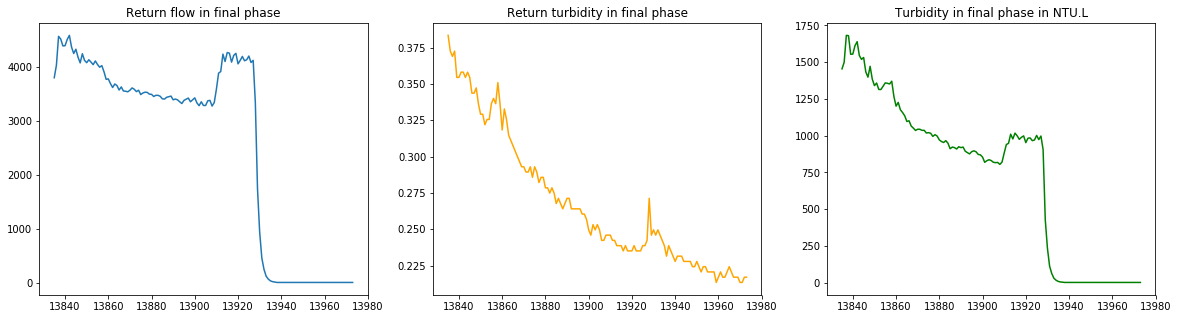

In [7]:
# plot flow, turbidity, and target 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(final_phase['return_flow'])
ax[0].set_title('Return flow in final phase')

ax[1].plot(final_phase['return_turbidity'], c='orange')
ax[1].set_title('Return turbidity in final phase')

ax[2].plot(final_phase['target'], c='green')
ax[2].set_title('Turbidity in final phase in NTU.L');

# Попробуем посмотреть на данные. Возможно, получится увидеть некоторые закономерности

In [8]:
import time
import csv
import pickle
import random
import time
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from functools import wraps
from matplotlib.font_manager import FontProperties
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

%matplotlib inline
pd.options.display.max_columns = None # выводить в датафрейме всё
%pylab inline
figsize(10, 3)


Populating the interactive namespace from numpy and matplotlib


In [9]:
train_data_ts = train_data.copy()
train_data_ts.index = train_data_ts['timestamp']

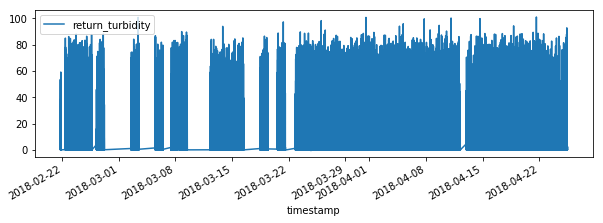

In [10]:
train_data_ts[['return_turbidity']].plot()

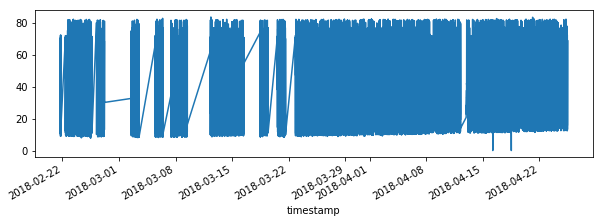

In [11]:
train_data_ts[train_data_ts['phase'] == 'final_rinse']['return_temperature'].plot()

In [12]:
train_data = train_data[train_data['phase'] != 'final_rinse']

In [13]:
#sum to get target
final_phase['target'].sum()

103724.28729467509

In [14]:
#confirm that value matches the target label for this process_id
train_labels.loc[20017]

final_rinse_total_turbidity_liter    103724.287295
Name: 20017, dtype: float64

Text(0.5, 1.0, 'Количество процессов в $N$-й фазе')

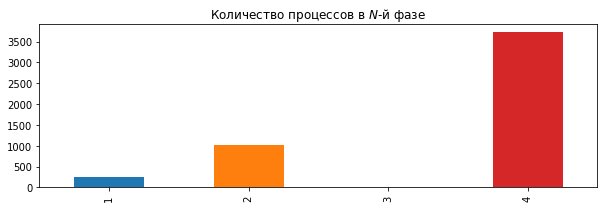

In [15]:
train_data.groupby('process_id')['phase'].nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов в $N$-й фазе")

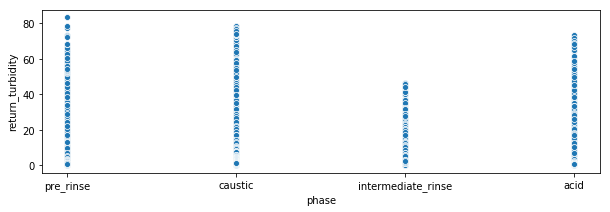

In [16]:
sns.scatterplot(train_data['phase'].head(100000), train_data['return_turbidity'].head(100000))

In [17]:
train_data

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20001,405,pre_rinse,2018-04-15 04:20:47,L4,8550.348,0.615451,18.044704,4.990765,0.177228,15776.9100,True,True,False,False,False,False,False,False,True,True,55.499672,41.555992,44.026875,49.474102,32.385708,83.036750,73.032410,45.394646,44.340126,False,0.0,False,0.0,False
1,20001,405,pre_rinse,2018-04-15 04:20:49,L4,11364.294,0.654297,18.229168,3.749680,0.122975,13241.4640,True,True,False,False,False,False,False,False,True,True,55.487920,41.624170,44.045685,49.457645,32.385708,83.015045,73.032410,45.394447,44.339380,False,0.0,False,0.0,False
2,20001,405,pre_rinse,2018-04-15 04:20:51,L4,12174.479,0.699870,18.395544,2.783954,0.387008,10698.7850,True,True,False,False,False,False,False,False,True,True,55.476166,41.638275,44.045685,49.462350,32.385708,83.015045,73.032410,45.396280,44.336735,False,0.0,False,0.0,False
3,20001,405,pre_rinse,2018-04-15 04:20:53,L4,13436.776,0.761502,18.583622,1.769353,0.213397,8007.8125,True,True,False,False,False,False,False,False,True,True,55.471466,41.647675,44.048030,49.462350,32.385708,83.036750,73.032410,45.401875,44.333110,False,0.0,False,0.0,False
4,20001,405,pre_rinse,2018-04-15 04:20:55,L4,13776.766,0.837240,18.627026,0.904020,0.148293,6004.0510,True,True,False,False,False,False,False,False,True,True,55.459705,41.654730,44.048030,49.462350,32.385708,83.015045,73.032410,45.398197,44.334373,False,0.0,False,0.0,False
5,20001,405,pre_rinse,2018-04-15 04:20:57,L4,18710.215,0.944444,18.583622,0.509684,0.166377,4918.9814,True,True,False,False,False,False,False,False,True,True,55.445602,41.647675,44.048030,49.462350,32.385708,82.993350,73.032410,45.385914,44.336000,False,0.0,False,0.0,False
6,20001,405,pre_rinse,2018-04-15 04:20:59,L4,21216.725,1.032118,18.460648,0.443773,0.292969,6188.5127,True,True,False,False,False,False,False,False,True,True,55.436195,41.628872,44.048030,49.462350,32.385708,82.993350,73.032410,45.369984,44.332523,False,0.0,False,0.0,False
7,20001,405,pre_rinse,2018-04-15 04:21:01,L4,22403.066,1.087891,18.420862,0.521089,0.271267,7606.3364,True,True,False,False,False,False,False,False,True,True,55.422090,41.603010,44.052734,49.462350,32.367622,82.953560,73.032410,45.381107,44.336490,False,0.0,False,0.0,False
8,20001,405,pre_rinse,2018-04-15 04:21:03,L4,23278.357,1.140842,18.420862,0.779835,0.361690,8586.5170,True,True,False,False,False,False,False,False,True,True,55.407990,41.565395,44.052734,49.462350,32.367622,82.953560,73.032410,45.402290,44.334263,False,0.0,False,0.0,False


### Создадим уникальный индентификатор фазы для каждого процесса:


In [18]:
train_data['process_phase'] = train_data.process_id.astype(str) + '_' + train_data.phase.astype(str)
process_phases = train_data.process_phase.unique()

# randomly select 93% of phases to keep
rng = np.random.RandomState(13)
to_keep = rng.choice(
                process_phases,
                size=np.int(len(process_phases) * 0.93),
                replace=False)

train_limited = train_data[train_data.process_phase.isin(to_keep)]

# subset labels to match our training data
train_labels = train_labels.loc[train_limited.process_id.unique()]

## Видим, что распределение процессов по фазам в тренировочной выборке и тестовой различаются

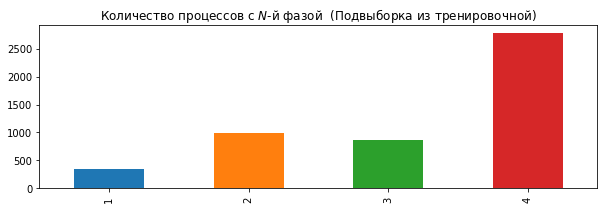

In [19]:
train_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов с $N$-й фазой  (Подвыборка из тренировочной)");

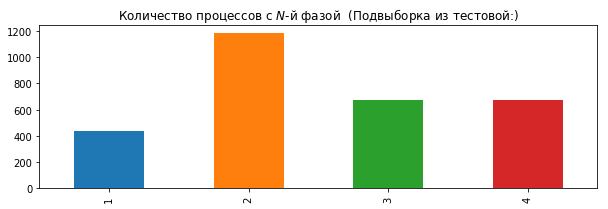

In [20]:
test_data.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов с $N$-й фазой  (Подвыборка из тестовой:)");

### Feature engineering

In [21]:
def prep_metadata(df):
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data
    if 'L12' not in meta.columns:
        meta['pipeline_L12'] = 0
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# show example for first 5,000 observations
prep_metadata(train_limited.head(5000))

,pipeline_L3,pipeline_L4,pipeline_L7,pipeline_L12,num_phases
process_id,,,,,
20001,0,1,0,0,3
20002,1,0,0,0,2
20003,1,0,0,0,4
20004,0,0,1,0,4
20005,0,0,1,0,1


In [24]:
#train_limited_with_phases_gr = train_limited.head(15).copy()
#phases = ['acid', 'caustic', 'pre_rinse']
#cols = train_limited_with_phases_gr.columns
#for col in cols[3:]:
#    for process in train_limited_with_phases_gr['process_id'].unique():
#        for phase in phases:
#            train_limited_with_phases_gr[col + '_' + phase] = train_limited[col][(train_limited['process_id'] == process) & (train_limited['phase'] == phase)]

In [25]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

## Преобразуем признаки временного ряда

In [26]:
import scipy as sc
def tail60mean(x):
    return x.tail(60).mean()

def tail60std(x):
    return x.tail(60).std()

def tail60median(x):
    return x.tail(60).median()

def tail60var(x):
    return x.tail(60).var()


def log_agg(x):
    return np.log(abs(x.tail(1)) + 0.1)




def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns

    ts_df = df[ts_cols].set_index('process_id')
    # create features: min, max, mean, standard deviation, and mean of the last 50 observations
    ts_features = ts_df.groupby('process_id').aggregate(['min', 'max', 'mean', 'std',
                                                             tail60mean,
                                                             tail60std,
                                                             log_agg,
                                                             tail60var,
                                                        'sum', 'mad'])
    
    return ts_features

# show example for first 5,000 observations
prep_time_series_features(train_limited.head(5000), columns=ts_cols)

supply_flow                                                        \
                    min         max          mean           std    tail60mean   
process_id                                                                      
20001         47.019676   59396.703  50103.211842  11397.417702  54375.964583   
20002          7.233796   34295.430  27142.963425   8337.197885  29972.692233   
20003      -1244.213000  103096.070  30455.285348  10152.968335  33415.738300   
20004        -43.402780   49537.035  31461.566686  12718.731413  36851.129117   
20005          0.000000   31116.176  28208.664393   7143.779052  30869.261683   

                                                                             \
              tail60std    log_agg     tail60var           sum          mad   
process_id                                                                    
20001       4268.329697  10.100100  1.821864e+07  6.814037e+07  7947.648538   
20002        249.084111  10.243775  6.204289e+04  1.210576e+07  5058.926236   
20003       3147.886174  10.321726  9.909187e+06  6.447384e+07  6782.761736   
20004       5135.883456  10.416917  2.637730e+07  2.598725e+07  8573.509529   
20005         48.108609  10.339365  2.314438e+03  7.080375e+06  4352.208419   

           supply_pressure                                                     \
                       min       max      mean       std tail60mean tail60std   
process_id                                                                      
20001            -0.036024  2.223741  1.693400  0.290767   1.696517  0.264640   
20002            -0.034071  2.170790  1.477925  0.421852   1.594419  0.031594   
20003            -0.033854  3.859375  2.687741  0.858450   2.968157  0.088533   
20004            -0.009549  0.482422  0.288591  0.160574   0.321799  0.120545   
20005            -0.023438  0.487196  0.417875  0.129448   0.466620  0.001302   

                                                      return_temperature  \
             log_agg tail60var          sum       mad                min   
process_id                                                                 
20001      -1.996518  0.070034  2303.023875  0.134970          13.888889   
20002       0.374582  0.000998   659.154517  0.233771           8.742043   
20003       1.159291  0.007838  5689.948363  0.533843          11.024305   
20004      -0.656584  0.014531   238.376303  0.145947          10.854311   
20005      -0.565078  0.000002   104.886719  0.081430          17.986834   

                                                                            \
                  max       mean        std tail60mean tail60std   log_agg   
process_id                                                                   
20001       82.530380  65.577520  22.264019  72.535265  0.044995  4.284227   
20002       76.392510  53.616841  22.887856  75.573942  0.538294  4.337193   
20003       81.586370  60.850462  22.457923  71.469483  0.021816  4.270826   
20004       82.490590  65.587009  21.269795  71.713445  0.148274  4.272341   
20005       71.520546  57.895270  19.108503  71.080850  0.151359  4.262760   

                                               return_conductivity             \
           tail60var            sum        mad                 min        max   
process_id                                                                      
20001       0.002025   89185.427283  18.956638            0.255486  57.301300   
20002       0.289761   23913.111281  19.047595            0.172301  46.425180   
20003       0.000476  128820.428049  20.322458            0.205189  46.821130   
20004       0.021985   54174.869593  16.854860            0.198415  48.217014   
20005       0.022910   14531.712894  16.943817            0.297533  50.747000   

                                                                           \
                 mean        std tail60mean tail60std   log_agg tail60var   
process_id                                  

In [27]:
def create_feature_matrix(df):
    metadata = prep_metadata(df)
    time_series = prep_time_series_features(df)
    # join metadata and time series features into a single dataframe
    feature_matrix = pd.concat([metadata, time_series], axis=1)
    
    return feature_matrix

In [28]:
train_features = create_feature_matrix(train_limited)


In [29]:
train_features.head(1000)

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,pipeline_L9,num_phases,"(supply_flow, min)","(supply_flow, max)","(supply_flow, mean)","(supply_flow, std)","(supply_flow, tail60mean)","(supply_flow, tail60std)","(supply_flow, log_agg)","(supply_flow, tail60var)","(supply_flow, sum)","(supply_flow, mad)","(supply_pressure, min)","(supply_pressure, max)","(supply_pressure, mean)","(supply_pressure, std)","(supply_pressure, tail60mean)","(supply_pressure, tail60std)","(supply_pressure, log_agg)","(supply_pressure, tail60var)","(supply_pressure, sum)","(supply_pressure, mad)","(return_temperature, min)","(return_temperature, max)","(return_temperature, mean)","(return_temperature, std)","(return_temperature, tail60mean)","(return_temperature, tail60std)","(return_temperature, log_agg)","(return_temperature, tail60var)","(return_temperature, sum)","(return_temperature, mad)","(return_conductivity, min)","(return_conductivity, max)","(return_conductivity, mean)","(return_conductivity, std)","(return_conductivity, tail60mean)","(return_conductivity, tail60std)","(return_conductivity, log_agg)","(return_conductivity, tail60var)","(return_conductivity, sum)","(return_conductivity, mad)","(return_turbidity, min)","(return_turbidity, max)","(return_turbidity, mean)","(return_turbidity, std)","(return_turbidity, tail60mean)","(return_turbidity, tail60std)","(return_turbidity, log_agg)","(return_turbidity, tail60var)","(return_turbidity, sum)","(return_turbidity, mad)","(return_flow, min)","(return_flow, max)","(return_flow, mean)","(return_flow, std)","(return_flow, tail60mean)","(return_flow, tail60std)","(return_flow, log_agg)","(return_flow, tail60var)","(return_flow, sum)","(return_flow, mad)","(tank_level_pre_rinse, min)","(tank_level_pre_rinse, max)","(tank_level_pre_rinse, mean)","(tank_level_pre_rinse, std)","(tank_level_pre_rinse, tail60mean)","(tank_level_pre_rinse, tail60std)","(tank_level_pre_rinse, log_agg)","(tank_level_pre_rinse, tail60var)","(tank_level_pre_rinse, sum)","(tank_level_pre_rinse, mad)","(tank_level_caustic, min)","(tank_level_caustic, max)","(tank_level_caustic, mean)","(tank_level_caustic, std)","(tank_level_caustic, tail60mean)","(tank_level_caustic, tail60std)","(tank_level_caustic, log_agg)","(tank_level_caustic, tail60var)","(tank_level_caustic, sum)","(tank_level_caustic, mad)","(tank_level_acid, min)","(tank_level_acid, max)","(tank_level_acid, mean)","(tank_level_acid, std)","(tank_level_acid, tail60mean)","(tank_level_acid, tail60std)","(tank_level_acid, log_agg)","(tank_level_acid, tail60var)","(tank_level_acid, sum)","(tank_level_acid, mad)","(tank_level_clean_water, min)","(tank_level_clean_water, max)","(tank_level_clean_water, mean)","(tank_level_clean_water, std)","(tank_level_clean_water, tail60mean)","(tank_level_clean_water, tail60std)","(tank_level_clean_water, log_agg)","(tank_level_clean_water, tail60var)","(tank_level_clean_water, sum)","(tank_level_clean_water, mad)","(tank_temperature_pre_rinse, min)","(tank_temperature_pre_rinse, max)","(tank_temperature_pre_rinse, mean)","(tank_temperature_pre_rinse, std)","(tank_temperature_pre_rinse, tail60mean)","(tank_temperature_pre_rinse, tail60std)","(tank_temperature_pre_rinse, log_agg)","(tank_temperature_pre_rinse, tail60var)","(tank_temperature_pre_rinse, sum)","(tank_temperature_pre_rinse, mad)","(tank_temperature_caustic, min)","(tank_temperature_caustic, max)","(tank_temperature_caustic, mean)","(tank_temperature_caustic, std)","(tank_temperature_caustic, tail60mean)","(tank_temperature_caustic, tail60std)","(tank_temperature_caustic, log_agg)","(tank_temperature_caustic, tail60var)","(tank_temperature_caustic, sum)","(tank_temperature_caustic, mad)","(tank_temperature_acid, min)","(tank_temperature_acid, max)","(tank_temperature_acid, mean)","(tank_temperature_acid, std)","(tank_temperature_acid, tail60mean)","(tank_temperature_acid, tail60std)","(tank_temperat

# Строим модели и тестируем их:

**Напишем функцию, которая считает ошибку предсказания. Для того, чтобы её можно было использовать вместе с sklearn воспользуемся sklearn.metrics.make_scorer:**

In [30]:
def mean_abs_percentage_err(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), np.full(np.shape(y_true), 290000)))

from sklearn.metrics import make_scorer
mape_modified_scorer = make_scorer(mean_abs_percentage_err, greater_is_better=False)
    

## Напишем функцию, которая тестирует модели на кросс-валидации и отложенной выборке

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
def models_validation(X, y, models, folds):
    kfold = KFold(folds)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 13)
    i = 0
    for model in models:
        i = i + 1
        model.fit(X_train, y_train)
        print(i, 'model cross-val:', np.mean(cross_val_score(model, X, y, scoring=mape_modified_scorer, cv=kfold, n_jobs=-1)))
        print(i, 'model on hold data:', mean_abs_percentage_err(model.predict(X_test), y_test))
        print('\n')
    return 0

## Воспользуемся TimeSeriesSplit для проведения кросс-валидации для временных рядом и GridSearchCV, чтобы найти оптимальные параметры для 

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, np.ravel(train_labels),
                                    train_size=0.7, random_state=13)

rf_regressor = RandomForestRegressor(n_estimators=50, random_state=13, n_jobs=-1, max_leaf_nodes=165, 
                                     min_samples_leaf=8, min_samples_split=0.005
#                                     max_depth=23,
#                                    max_leaf_nodes= 100,
#                                     min_samples_leaf = 5,
                                     
      
                                    #max_features=17,
                                   # criterion = 'mse',
                                  
                                    )
rf_param_grid =  {
                  'n_estimators' : [50],
                  'random_state' : [13], 
                  #'n_jobs=-1' : [-1],
                  'max_depth' : [35],
                  'max_features' : [40, 50, 80],
                  'min_weight_fraction_leaf' : [0.5, 0.1, 0.01, 0.0001,  0.00001],
                  'min_impurity_decrease' : [0.00001, 0.001, 0.01, 0.1, 1],
                  'min_impurity_split' : [0.00001, 0.001, 0.01, 0.1, 0.5]
                 # 'min_samples_leaf' : list(np.arange(2, 13)) + [20, 25, 50],
                 # 'max_leaf_nodes' : list(np.arange(2, 13)) + [20, 25, 50]
                                        }                 
rf_grid = GridSearchCV(estimator=rf_regressor, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=rf_param_grid)

#sgd_regr = SGDRegressor(penalty='elasticnet', penalty='l1')

In [ ]:
#rf_grid.fit(X_train, y_train)
train_features_xgb = train_features.copy()
for col_name in train_features_xgb.columns:
    new_col_name = str(col_name).replace(">", "")
    new_col_name = str(new_col_name).replace("<", "")
    new_col_name = str(new_col_name).replace(",", "")
    new_col_name = str(new_col_name).replace("[", "")
    new_col_name = str(new_col_name).replace("]", "")
    train_features_xgb[new_col_name] = train_features_xgb[col_name]
    train_features_xgb.pop(col_name)

## Оптимальные параметры и лучший результат rf:

In [38]:
#rf_grid.best_params_, rf_grid.best_score_
#({'max_depth': 20,
#  'max_features': 40,
#  'min_samples_leaf': 5,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6180501020995538)
#{'max_depth': 20,
#  'max_features': 50,
#  'max_leaf_nodes': 50,
#  'min_samples_leaf': 3,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6628379946829989

rf_after_grid = RandomForestRegressor(n_estimators=300, max_depth=35, #max_features=100, 
                                      min_samples_leaf=8, max_leaf_nodes = 200, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      bootstrap=False,
                                      random_state=13)
rf_after_grid.fit(X_train, y_train)
#rf_grid.best_params_, rf_grid.best_score_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=200,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

## Воспользуемся RFE для того, чтобы отобрать важные признаки:

In [73]:
from sklearn.svm import SVR
svr = SVR(C=0.01, epsilon=1, kernel='sigmoid', coef0=1, max_iter=1000)
from sklearn.linear_model import Ridge
ridge = Ridge(alpha =  0.9, random_state=13, max_iter = 1000, tol = 0.0000001)
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train_data_scaled = train_features.copy()
train_data_scaled = minmax.fit_transform(train_data_scaled)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(train_data_scaled, np.ravel(train_labels),
                                                                 train_size=0.7, random_state=13)


In [74]:
from sklearn.feature_selection import RFECV, SelectKBest
rfecv = RFECV(estimator=ridge, step = 1, n_jobs=-1, scoring=mape_modified_scorer,
              cv=TimeSeriesSplit(5))


In [75]:
rfecv.fit(X_train_scaled, y_train)

RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
   estimator=Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=13, solver='auto', tol=1e-07),
   min_features_to_select=1, n_jobs=-1,
   scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
   step=1, verbose=0)

In [77]:
mean_abs_percentage_err(rfecv.predict(X_test_scaled), y_test) - 0.9170895496280376
#2.1592417953441427

2.023935372960959

In [39]:
models_validation(train_features, np.ravel(train_labels), [rf_after_grid], folds=5)

1 model cross-val: -0.7584292298743855
1 model on hold data: 1.0564719297407563




0

In [62]:
from sklearn.feature_selection import SelectPercentile
kbest = SelectPercentile(score_func=mape_modified_scorer)
kbest.fit(X=X_train, y=y_train)

TypeError: __call__() missing 1 required positional argument: 'y_true'

## Добавим Knn и проверим эту модель на шкалированных данных

In [45]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7, p = 2)
extra_trees = ExtraTreesRegressor( n_estimators=200, max_depth=45, #max_features=100, 
                                      min_samples_leaf=5, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      random_state=13)
bagging = BaggingRegressor(max_samples=0.85, n_estimators=10, )
svr = SVR(C=0.01, epsilon=1, kernel='sigmoid', coef0=1, max_iter=1000)
rdg = Ridge()
lss = Lasso()
els = ElasticNet(copy_X=True)
rfecv = RFECV(estimator=extra_trees, step = 15, n_jobs=-1, scoring=mape_modified_scorer,
              cv=TimeSeriesSplit(3))

In [46]:
models_validation(train_data_scaled, np.ravel(train_labels), [knn, extra_trees, bagging, svr, rdg, lss, els], folds=5)

1 model cross-val: -1.2984858868075166
1 model on hold data: 3.1987743411088436


2 model cross-val: -1.0117036757498852
2 model on hold data: 3.04791758717017


3 model cross-val: -1.4379192969409227
3 model on hold data: 3.641191493764286


4 model cross-val: -2.4116018918505695
4 model on hold data: 0.9877977571959007


5 model cross-val: -1.2804308053712246
5 model on hold data: 3.330082066343979


6 model cross-val: -1.4474951438249117
6 model on hold data: 3.9409472102732113


7 model cross-val: -0.9970132470919354
7 model on hold data: 2.9015466184422363




0

## Результат сравним с RandomForest! Настроим knn:

In [152]:
knn_grid_params = {'n_neighbors' : list(np.arange(2, 10)) + [ 40, 41, 42, 43, 44, 45, 46, 47 ],
                  'leaf_size' : list(np.arange(2, 10) + [15, 20, 25, 30, 50, 70, 90, 110])}
knn_grid = GridSearchCV(estimator=knn, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=knn_grid_params)

In [262]:
knn_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=7, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47], 'leaf_size': [17, 23, 29, 35, 56, 77, 98, 119]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbose=2)

In [196]:
knn_grid.best_params_, knn_grid.best_score_

NameError: name 'knn_grid' is not defined

In [47]:
knn_after_grid = KNeighborsRegressor(metric='braycurtis',n_neighbors=44, p=2, weights='distance')
knn_bagging = BaggingRegressor(base_estimator=knn_after_grid, max_samples=0.9, max_features=0.8, n_jobs=-1,
                              n_estimators=30)

In [48]:
models_validation(train_data_scaled, np.ravel(train_labels), [knn_after_grid], 5)

1 model cross-val: -1.0855751026543954
1 model on hold data: 2.859974779720699




0

In [67]:
knn_after_grid.fit(train_data_scaled, np.ravel(train_labels))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=44, p=3,
          weights='distance')

## Попробуем использовать

In [48]:
rf_after_grid.fit(train_data_scaled, np.ravel(train_labels))

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=200,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [41]:
test_features = create_feature_matrix(test_data)


In [42]:
test_features = minmax.transform(test_features)

In [49]:
preds = rf_after_grid.predict(test_features)

In [50]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [51]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [52]:
my_submission.to_csv('./submissions/7th_try_to_beat_benchmark_2.csv')

In [79]:
mape_modified_scorer(rf_after_grid, X_test, y_test), mean_abs_percentage_err(rf_after_grid.predict(X_test), y_test)

(-0.549157172260939, 0.9148239861830831)

## NEURAL NET

In [40]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train_features_scaled = train_features.copy()
train_features_scaled = minmax.fit_transform(train_features_scaled)

mlp = MLPRegressor(solver='lbfgs', random_state=13, hidden_layer_sizes=50, batch_size=1000,
                  )


## CatBoost

In [41]:
from catboost import CatBoostRegressor
catboost1 = CatBoostRegressor(custom_metric='MAPE', depth = 6)

In [42]:
models_validation(train_features, np.ravel(train_labels), [catboost1], 5)
#1 model cross-val: -0.7123923207389505
#1 model on hold data: 1.3027737118835103


Got unsafe target value = 1.94472e+06 at object #0 of dataset learn


0:	learn: 6694010.2299740	total: 209ms	remaining: 3m 28s
1:	learn: 6614198.1247368	total: 280ms	remaining: 2m 19s
2:	learn: 6549686.8595806	total: 340ms	remaining: 1m 53s
3:	learn: 6504017.0693568	total: 398ms	remaining: 1m 39s
4:	learn: 6435353.0624519	total: 472ms	remaining: 1m 33s
5:	learn: 6383717.8562561	total: 537ms	remaining: 1m 28s
6:	learn: 6315442.9872386	total: 595ms	remaining: 1m 24s
7:	learn: 6258776.9765074	total: 654ms	remaining: 1m 21s
8:	learn: 6193951.5903820	total: 721ms	remaining: 1m 19s
9:	learn: 6136714.5275501	total: 790ms	remaining: 1m 18s
10:	learn: 6091155.1629002	total: 848ms	remaining: 1m 16s
11:	learn: 6054621.4655730	total: 907ms	remaining: 1m 14s
12:	learn: 6003366.9992137	total: 983ms	remaining: 1m 14s
13:	learn: 5951644.5090197	total: 1.05s	remaining: 1m 13s
14:	learn: 5902379.2674592	total: 1.11s	remaining: 1m 12s
15:	learn: 5858839.8339573	total: 1.17s	remaining: 1m 11s
16:	learn: 5821052.3072529	total: 1.23s	remaining: 1m 11s
17:	learn: 5775382.80737

145:	learn: 3888335.9334017	total: 9.19s	remaining: 53.7s
146:	learn: 3880233.5918422	total: 9.25s	remaining: 53.7s
147:	learn: 3875975.0911584	total: 9.31s	remaining: 53.6s
148:	learn: 3867191.3366026	total: 9.36s	remaining: 53.5s
149:	learn: 3862422.3155922	total: 9.43s	remaining: 53.4s
150:	learn: 3857001.8784017	total: 9.49s	remaining: 53.3s
151:	learn: 3848120.9195561	total: 9.55s	remaining: 53.3s
152:	learn: 3842935.5478824	total: 9.6s	remaining: 53.2s
153:	learn: 3838926.5435111	total: 9.66s	remaining: 53.1s
154:	learn: 3834333.2116712	total: 9.72s	remaining: 53s
155:	learn: 3829067.3383408	total: 9.78s	remaining: 52.9s
156:	learn: 3822769.4258075	total: 9.84s	remaining: 52.8s
157:	learn: 3819967.5524249	total: 9.9s	remaining: 52.8s
158:	learn: 3815940.5277100	total: 9.96s	remaining: 52.7s
159:	learn: 3810672.1610627	total: 10s	remaining: 52.6s
160:	learn: 3806075.3182532	total: 10.1s	remaining: 52.5s
161:	learn: 3797800.8939352	total: 10.1s	remaining: 52.5s
162:	learn: 3796311.

290:	learn: 3319249.4867689	total: 17.8s	remaining: 43.4s
291:	learn: 3318041.2695020	total: 17.9s	remaining: 43.4s
292:	learn: 3316687.7790292	total: 17.9s	remaining: 43.3s
293:	learn: 3309267.0212533	total: 18s	remaining: 43.2s
294:	learn: 3301344.5051442	total: 18.1s	remaining: 43.2s
295:	learn: 3300215.8040361	total: 18.1s	remaining: 43.1s
296:	learn: 3298394.9909667	total: 18.2s	remaining: 43.1s
297:	learn: 3294181.5495608	total: 18.3s	remaining: 43s
298:	learn: 3289004.8843314	total: 18.3s	remaining: 43s
299:	learn: 3282685.2517222	total: 18.4s	remaining: 42.9s
300:	learn: 3282430.6835526	total: 18.4s	remaining: 42.8s
301:	learn: 3280739.1843399	total: 18.5s	remaining: 42.7s
302:	learn: 3279091.1281024	total: 18.6s	remaining: 42.7s
303:	learn: 3274024.1664581	total: 18.6s	remaining: 42.7s
304:	learn: 3273146.2077737	total: 18.7s	remaining: 42.6s
305:	learn: 3272113.7226522	total: 18.8s	remaining: 42.5s
306:	learn: 3264038.6865705	total: 18.8s	remaining: 42.5s
307:	learn: 3264024.

435:	learn: 2900122.6299015	total: 26.5s	remaining: 34.3s
436:	learn: 2899568.5339358	total: 26.5s	remaining: 34.2s
437:	learn: 2898788.5301397	total: 26.6s	remaining: 34.1s
438:	learn: 2893271.0670098	total: 26.7s	remaining: 34.1s
439:	learn: 2891005.5761047	total: 26.7s	remaining: 34s
440:	learn: 2887046.7735766	total: 26.8s	remaining: 34s
441:	learn: 2880874.1710680	total: 26.8s	remaining: 33.9s
442:	learn: 2880332.0425842	total: 26.9s	remaining: 33.8s
443:	learn: 2875101.1471542	total: 27s	remaining: 33.8s
444:	learn: 2874231.8014631	total: 27s	remaining: 33.7s
445:	learn: 2868423.5984116	total: 27.1s	remaining: 33.6s
446:	learn: 2867632.7311332	total: 27.1s	remaining: 33.6s
447:	learn: 2864107.0963380	total: 27.2s	remaining: 33.5s
448:	learn: 2863337.6576397	total: 27.3s	remaining: 33.5s
449:	learn: 2862610.6219251	total: 27.3s	remaining: 33.4s
450:	learn: 2860322.2198982	total: 27.4s	remaining: 33.3s
451:	learn: 2859852.1821404	total: 27.4s	remaining: 33.3s
452:	learn: 2854715.22

581:	learn: 2567371.3442009	total: 35.4s	remaining: 25.4s
582:	learn: 2563867.3676159	total: 35.5s	remaining: 25.4s
583:	learn: 2562168.3677309	total: 35.5s	remaining: 25.3s
584:	learn: 2559403.7922431	total: 35.6s	remaining: 25.2s
585:	learn: 2558228.9954661	total: 35.7s	remaining: 25.2s
586:	learn: 2554972.2781255	total: 35.7s	remaining: 25.1s
587:	learn: 2554628.1793835	total: 35.8s	remaining: 25.1s
588:	learn: 2554325.7738652	total: 35.8s	remaining: 25s
589:	learn: 2552495.9382617	total: 35.9s	remaining: 24.9s
590:	learn: 2550788.2809632	total: 36s	remaining: 24.9s
591:	learn: 2550456.6812419	total: 36s	remaining: 24.8s
592:	learn: 2547730.8538877	total: 36.1s	remaining: 24.8s
593:	learn: 2546708.2791786	total: 36.1s	remaining: 24.7s
594:	learn: 2546262.0904154	total: 36.2s	remaining: 24.6s
595:	learn: 2546019.8414504	total: 36.3s	remaining: 24.6s
596:	learn: 2545863.8420919	total: 36.3s	remaining: 24.5s
597:	learn: 2542992.5910752	total: 36.4s	remaining: 24.5s
598:	learn: 2542809.

725:	learn: 2362122.2162752	total: 44.1s	remaining: 16.6s
726:	learn: 2361629.5946743	total: 44.2s	remaining: 16.6s
727:	learn: 2358826.4267107	total: 44.2s	remaining: 16.5s
728:	learn: 2358793.3033912	total: 44.3s	remaining: 16.5s
729:	learn: 2358277.0915492	total: 44.3s	remaining: 16.4s
730:	learn: 2358086.9079066	total: 44.4s	remaining: 16.3s
731:	learn: 2356799.8514210	total: 44.5s	remaining: 16.3s
732:	learn: 2355525.3807256	total: 44.5s	remaining: 16.2s
733:	learn: 2355481.0217683	total: 44.6s	remaining: 16.2s
734:	learn: 2355385.1409634	total: 44.6s	remaining: 16.1s
735:	learn: 2355290.5044357	total: 44.7s	remaining: 16s
736:	learn: 2353448.7897371	total: 44.8s	remaining: 16s
737:	learn: 2352528.1250948	total: 44.8s	remaining: 15.9s
738:	learn: 2351750.6395182	total: 44.9s	remaining: 15.8s
739:	learn: 2351561.5816212	total: 44.9s	remaining: 15.8s
740:	learn: 2351409.7926093	total: 45s	remaining: 15.7s
741:	learn: 2350920.2414510	total: 45.1s	remaining: 15.7s
742:	learn: 2349417.

869:	learn: 2229758.5627811	total: 52.7s	remaining: 7.88s
870:	learn: 2226742.8736496	total: 52.8s	remaining: 7.82s
871:	learn: 2224784.1182878	total: 52.8s	remaining: 7.76s
872:	learn: 2224729.4199878	total: 52.9s	remaining: 7.7s
873:	learn: 2223838.3403778	total: 53s	remaining: 7.64s
874:	learn: 2223519.7859845	total: 53s	remaining: 7.58s
875:	learn: 2223320.8015746	total: 53.1s	remaining: 7.51s
876:	learn: 2220953.8819589	total: 53.1s	remaining: 7.45s
877:	learn: 2220888.2500409	total: 53.2s	remaining: 7.39s
878:	learn: 2220859.3853918	total: 53.3s	remaining: 7.33s
879:	learn: 2220811.7287617	total: 53.3s	remaining: 7.27s
880:	learn: 2220763.2570579	total: 53.4s	remaining: 7.21s
881:	learn: 2220648.1567168	total: 53.4s	remaining: 7.15s
882:	learn: 2220630.9603630	total: 53.5s	remaining: 7.09s
883:	learn: 2219028.3335421	total: 53.6s	remaining: 7.03s
884:	learn: 2218970.4680270	total: 53.6s	remaining: 6.97s
885:	learn: 2218765.4833421	total: 53.7s	remaining: 6.91s
886:	learn: 2218663

0

## LightGBM

In [79]:
from lightgbm import LGBMRegressor
lightgbm1 = LGBMRegressor(objective='poisson', num_leaves = 1000, max_bin = 400, #min_data_in_leaf = 100, num_leaves = ,
                          n_estimators=100
                            # learning_rate=0.01, num_iteration = 1000,
                         )
lightgbm2 = LGBMRegressor(objective = "gamma",
metric = "mape",
max_depth = 7,
num_leaves = 100,
learning_rate = 0.01,
bagging_fraction = 0.3,
feature_fraction = 0.15,
lambda_l1 = 5,
lambda_l2 = 5,
                         subsample = 0.95,
                         top_rate = 0.906,
                        # min_child_weight=42,
                         other_rate = 0.07,
                         reg_alpha = 9.6,
                         colsample_bytree = 0.57,
                         min_split_gain = 10,
                         reg_lambda = 8.3,
                         min_data_in_leaf = 21,
                         seed = 13)

In [80]:
#lgb = LGBMRegressor()
#params ={
#                'task': 'train',
#                'boosting': 'goss',
#                'objective': 'regression',
#                'metric': 'rmse',
#                'learning_rate': 0.01,
#                'subsample': 0.9855232997390695,
#                'max_depth': 7,
#                'top_rate': 0.9064148448434349,
#                'num_leaves': 63,
#                'min_child_weight': 41.9612869171337,
#                'other_rate': 0.0721768246018207,
#                'reg_alpha': 9.677537745007898,
#                'colsample_bytree': 0.5665320670155495,
#                'min_split_gain': 9.820197773625843,
#                'reg_lambda': 8.2532317400459,
#                'min_data_in_leaf': 21,
#                'verbose': -1,
#                'seed':int(2**n_fold),
#                'bagging_seed':int(2**n_fold),
#                'drop_seed':int(2**n_fold)
#                }

In [81]:
models_validation(train_features, np.ravel(train_labels), [lightgbm2], 5)

1 model cross-val: -0.7975967753831437
1 model on hold data: 0.9021944620989151




0

# Все-таки попробуем XGB:

In [87]:
# так как не любит присутствие данных символов в названиях признаков
train_features_xgb = train_features.copy()
for col_name in train_features_xgb.columns:
    new_col_name = str(col_name).replace(">", "").replace("<", "").replace("[", "").replace("]", "")
    train_features_xgb[new_col_name] = train_features_xgb[col_name]
    train_features_xgb.pop(col_name)

In [114]:
from xgboost import XGBRegressor
xgb = XGBRegressor(booster='gbtree', n_estimators=1000, max_depth=5, n_jobs=-1,
                  learning_rate=0.05, min_child_weight=10, 
                  random_state=13, colsample_bytree=0.75, colsample_bylevel=0.90,
                  objective='reg:tweedie', subsample = 0.8, tweedie_variance_power = 2, gamma=3,
                  max_delta_step=3)
xgb_param_grid = {
                  'colsample_bytree' : [0.5, 0.6, 0.7, 0.85, 1],
                  'colsample_bylevel' : [0.5, 0.6, 0.7, 0.85, 1],
                  'objective' : ['reg:gamma', 'reg:tweedie'],
                  'min_child_weight' : [2],
                  'subsample' : [0.5, 0.6, 0.85],
                  'max_delta_step' : [2, 3]
                 }
xgb_after_grid = XGBRegressor(booster='gbtree', n_estimators=10000, max_depth=6, n_jobs=-1,
                  learning_rate=0.01, min_child_weight=10,
                  random_state=13, colsample_bytree=0.7, colsample_bylevel=0.9,
                  objective='reg:gamma', subsample = 0.8, tweedie_variance_power = 2, gamma=1.23,
                  max_delta_step=4)

In [113]:
models_validation(train_features_xgb, np.ravel(train_labels), [xgb_after_grid], 5)
#1 model cross-val: -0.6458502902125065
#1 model on hold data: 0.4569836013484545 //with tail std

#1 model cross-val: -0.6147255465470229 //0.93
#1 model on hold data: 0.41715442776597006



#2 model cross-val: -0.6873577323775079, bytree=0.7, bylevel=0.9
#2 model on hold data: 0.4063711038046714

#2 model cross-val: -0.613499015779851 //0.93
#2 model on hold data: 0.385689123950636

1 model cross-val: -0.6220400018375083
1 model on hold data: 0.3854021340787236




0

In [ ]:
xgb_grid.best_score_, xgb_grid.best_params_

## Попробуем использовать XGB, настроенный на GridSearch 

In [115]:
xgb_after_grid.fit(train_features_xgb, np.ravel(train_labels))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.7, gamma=1.23, learning_rate=0.01,
       max_delta_step=4, max_depth=6, min_child_weight=10, missing=None,
       n_estimators=10000, n_jobs=-1, nthread=None, objective='reg:gamma',
       random_state=13, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8, tweedie_variance_power=2)

In [ ]:
test_features = create_feature_matrix(test_data)


In [ ]:
test_features_xgb = test_features.copy()
for col_name in test_features_xgb.columns:
    new_col_name = str(col_name).replace(">", "").replace("<", "").replace("[", "").replace("]", "")
    test_features_xgb[new_col_name] = test_features_xgb[col_name]
    test_features_xgb.pop(col_name)

In [ ]:
preds = xgb_after_grid.predict(test_features_xgb)

In [ ]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [ ]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.to_csv('./submissions/13th_submission.csv')

In [89]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
ridge_param_grid = {'alpha' : [1.001, 20000, 0.00000001, 0.00001, 0.00004, 0.5, 0.8, 0.9],
                    'tol' : list(0.1 + np.arange(50) / 5000) + [1, 2, 5, 10]}
ridge = Ridge(normalize=True, fit_intercept=True, max_iter=500 )
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=TimeSeriesSplit(5), 
                         verbose=1, scoring=mape_modified_scorer)
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed:   12.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=500,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1.001, 20000, 1e-08, 1e-05, 4e-05, 0.5, 0.8, 0.9], 'tol': [0.1, 0.10020000000000001, 0.1004, 0.10060000000000001, 0.1008, 0.101, 0.10120000000000001, 0.1014, 0.10160000000000001, 0.1018, 0.10200000000000001, 0.1022, 0.1024, 0.10260000000000001, 0.1028, 0.10300000000000001, 0.10... 0.10880000000000001, 0.109, 0.1092, 0.10940000000000001, 0.1096, 0.10980000000000001, 1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbose=1)

In [90]:
ridge_grid.best_params_

{'alpha': 1.001, 'tol': 0.1}

In [91]:
mape_modified_scorer(ridge_grid, X_test, y_test), mean_abs_percentage_err(ridge_grid.predict(X_test), y_test)

(-0.8668668309153095, 2.147872467088798)

In [56]:
preds = sgd.predict(test_features)

In [57]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [58]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [59]:
my_submission.to_csv('./submissions/4th_try_to_beat_benchmark.csv')

In [2]:
import pandas as pd
import numpy as np
subm_1 = pd.read_csv('./submissions/9th_submission.csv', index_col=0)
subm_2 = pd.read_csv('./submissions/9th_submission.csv', index_col=0)
subm_3 = pd.read_csv('./submissions/13th_submission.csv', index_col=0)
subm_4 = pd.read_csv('./submissions/11th_submission_1.csv', index_col=0)
np.mean(subm_3['final_rinse_total_turbidity_liter'] - subm_2['final_rinse_total_turbidity_liter'])

43774.26589484335

In [9]:
my_subm = subm_1.copy()
my_subm['final_rinse_total_turbidity_liter'] = 0.3 * subm_1['final_rinse_total_turbidity_liter'] \
                                        + 0.3 * subm_2['final_rinse_total_turbidity_liter'] \
                                        + 0.2 * subm_3['final_rinse_total_turbidity_liter'] \
                                        + 0.2 * subm_4['final_rinse_total_turbidity_liter']
my_subm.to_csv('./submissions/13th_submission(mean of 4 xgb).csv')

In [8]:
np.mean(my_subm['final_rinse_total_turbidity_liter'] - subm_1['final_rinse_total_turbidity_liter'])

46795.84030819002